In [111]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
import lightgbm as lgb

## Loading data

In [116]:
data_dir = os.getcwd() + '/yelp_dataset'
data = pd.read_pickle(os.path.join(data_dir, 'features.pkl'))

In [56]:
# take 20% opened business data
# data_open = data[data['is_open']==1]
# data_close = data[data['is_open']==0]
# data_sampled = pd.concat([data_close, data_open.sample(frac=0.2, random_state=21)])

## Preprocessing

In [117]:
# prepare data sets for modeling
def prepare_data(data):
    drop_list = ['address', 'attributes', 'business_id', 'categories', 'city', 'hours',
                 'latitude', 'longitude', 'name', 'postal_code', 'state', 'stars',]

    data = data.drop(columns=drop_list).dropna()
    data = data.replace([np.inf, -np.inf], 0)
    X = data.drop(columns='is_open')
    y = data['is_open']
    
    return X, y

In [118]:
# Oversampling
from sklearn.utils import resample

def resampling_data(data):
    # separate features and labels
    X, y = prepare_data(data)
    # split the data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    # concatenate training data back 
    t_data = pd.concat([X_train, y_train], axis=1)
    # separate open and close businesses
    data_open = t_data[t_data['is_open']==1]
    data_close = t_data[t_data['is_open']==0]
    # oversample minority
    n_samples = int(len(data_open)*0.8) 
    data_close_sampled = resample(data_close, replace=True, n_samples=n_samples, random_state=42)
    # combine majority and oversampled minority
    data_sampled = pd.concat([data_open, data_close_sampled])
    
    return data_sampled, X_test, y_test

data_sampled, X_test, y_test = resampling_data(data)

## Tuning Parameters

In [110]:
parameters = {
     'num_leaves': [10, 30, 50, 80],
     'min_data_in_leaf': [100, 300, 700, 1000],
     'learning_rate': [0.05, 0.1, 0.15, 0.2],
     }

# apply GridSearch on random forest regression to find the best parameter 
gs = GridSearchCV(lgb.LGBMClassifier(objective='binary', n_estimators=1000), 
                   parameters, 
                   cv=5, 
                   scoring='f1', 
                   n_jobs=-1,
                   verbose=2)

gs.fit(X_train, y_train)
print('The best parameters are:\n')
print(gs.best_estimator_)

means = gs.cv_results_['mean_test_score']
stds = gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  6.3min finished


The best parameters are:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.05, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=100,
        min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=10,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)
0.915 (+/-0.005) for {'learning_rate': 0.05, 'min_data_in_leaf': 100, 'num_leaves': 10}
0.913 (+/-0.005) for {'learning_rate': 0.05, 'min_data_in_leaf': 100, 'num_leaves': 30}
0.913 (+/-0.005) for {'learning_rate': 0.05, 'min_data_in_leaf': 100, 'num_leaves': 50}
0.912 (+/-0.007) for {'learning_rate': 0.05, 'min_data_in_leaf': 100, 'num_leaves': 80}
0.915 (+/-0.003) for {'learning_rate': 0.05, 'min_data_in_leaf': 300, 'num_leaves': 10}
0.911 (+/-0.006) for {'learning_rate': 0.05, 'min_data_in_leaf': 300, 'num

In [122]:
def cross_validation(X, y):
    scores = []
    cv = KFold(n_splits=10, random_state=None, shuffle=True)
    lgb_model = lgb.LGBMClassifier(n_estimators=1000,
                                       objective='binary',
                                       num_leaves=10,
                                       min_data_in_leaf=100,
                                       learning_rate=0.05,
                                       n_jobs=-1   
                                       )
    for train_index, test_index in cv.split(X):
        
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_test)
        print(classification_report(y_test, y_pred))
        print('----------------------------------------------------------')
        
    return lgb_model
    
lgb_model = cross_validation(data_sampled.drop(columns='is_open'), data_sampled['is_open'])

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3807
           1       0.95      0.95      0.95      4719

   micro avg       0.94      0.94      0.94      8526
   macro avg       0.94      0.94      0.94      8526
weighted avg       0.94      0.94      0.94      8526

----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3744
           1       0.94      0.95      0.95      4782

   micro avg       0.94      0.94      0.94      8526
   macro avg       0.94      0.94      0.94      8526
weighted avg       0.94      0.94      0.94      8526

----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      3809
           1       0.93      0.95      0.94      4717

   micro avg       0.94      0.94      0.94      8526
   macro a

## lightGBM

              precision    recall  f1-score   support

           0       0.77      0.87      0.81      4475
           1       0.97      0.95      0.96     23192

   micro avg       0.94      0.94      0.94     27667
   macro avg       0.87      0.91      0.89     27667
weighted avg       0.94      0.94      0.94     27667



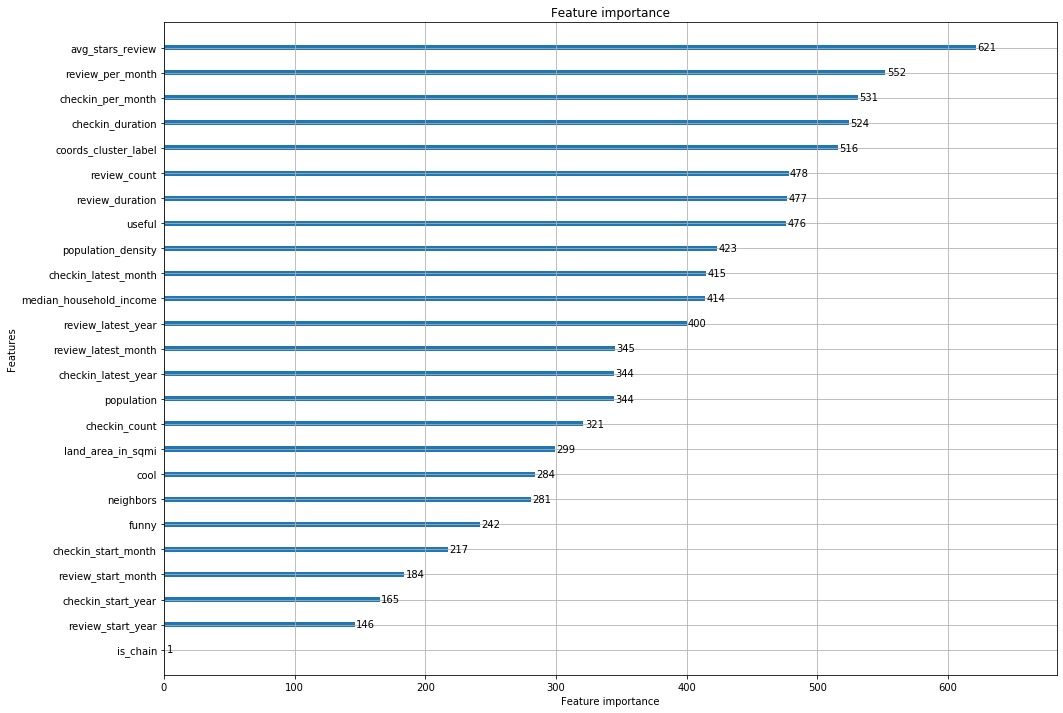

-----------------------------------------------------------
Confusion matrix
[[ 3890   585]
 [ 1192 22000]]
-----------------------------------------------------------
Accuracy is: 93.58%


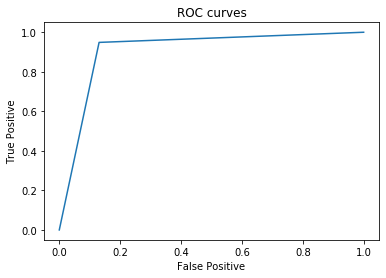

In [123]:
# def lightgbm_model(X, y):
#     # split the data into test and training sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
#     # initialize lightGBM mdoel
#     lgb_model = lgb.LGBMClassifier(n_estimators=1000,
#                                objective='binary',
#                                num_leaves=10,
#                                min_data_in_leaf=100,
#                                learning_rate=0.05,
#                                n_jobs=-1   
#                                )
#     # fit the model
#     lgb_model.fit(X_train, y_train)
# #     y_pred = lgb_model.predict(X_test)
#     # results
#     print('lightGBM score for training set: %f' % lgb_model.score(X_train, y_train))
#     print('lightGBM score for testing set: %f' % lgb_model.score(X_test, y_test))
#     print('-----------------------------------------------------------')
# #     print(classification_report(y_test, y_pred))
# #     fig, axes = plt.subplots()
# #     fig.set_size_inches(16, 12)
# #     lgb.plot_importance(lgb_model, ax=axes)
# #     plt.show()
    
#     return lgb_model

# lgb_model = lightgbm_model(data_sampled.drop(columns='is_open'), data_sampled['is_open'])
y_pred = lgb_model.predict(X_test)
print(classification_report(y_test, y_pred))
fig, axes = plt.subplots()
fig.set_size_inches(16, 12)
lgb.plot_importance(lgb_model, ax=axes)
plt.show()

# get confusion matrix
print('-----------------------------------------------------------')
print('Confusion matrix')
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('-----------------------------------------------------------')
accuracy= str(np.round((cm[0][0] + cm[1][1])/np.sum(cm), 4) *100)+'%' 
print("Accuracy is: {}".format(accuracy))
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(cm)
# plt.title('Confusion matrix of the classifier')
# fig.colorbar(cax)
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()
fp, tp, _ = roc_curve(y_test, y_pred)
plt.plot(fp, tp, label='lighGBM')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC curves')
plt.show()

## Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression

def logistic_regression_model(X, y):
    # split the data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21)
    # initial logistic regression model
    lr = LogisticRegression(solver='liblinear', max_iter=1000)
    # fit the model
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    # classification results
    print('Logistic regression score for training set: %f' % lr.score(X_train, y_train))
    print('Logistic regression score for testing set: %f' % lr.score(X_test, y_test))
    print(classification_report(y_test, y_pred))

logistic_regression_model(X, y)

Logistic regression score for training set: 0.715251
Logistic regression score for testing set: 0.709071
              precision    recall  f1-score   support

           0       0.71      0.68      0.69      4396
           1       0.71      0.74      0.72      4644

   micro avg       0.71      0.71      0.71      9040
   macro avg       0.71      0.71      0.71      9040
weighted avg       0.71      0.71      0.71      9040



## Random Forests

Random Forests score for training set: 0.898132
Random Forests score for testing set: 0.897821
-----------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.36      0.53      4352
           1       0.89      1.00      0.94     23315

   micro avg       0.90      0.90      0.90     27667
   macro avg       0.93      0.68      0.73     27667
weighted avg       0.91      0.90      0.88     27667



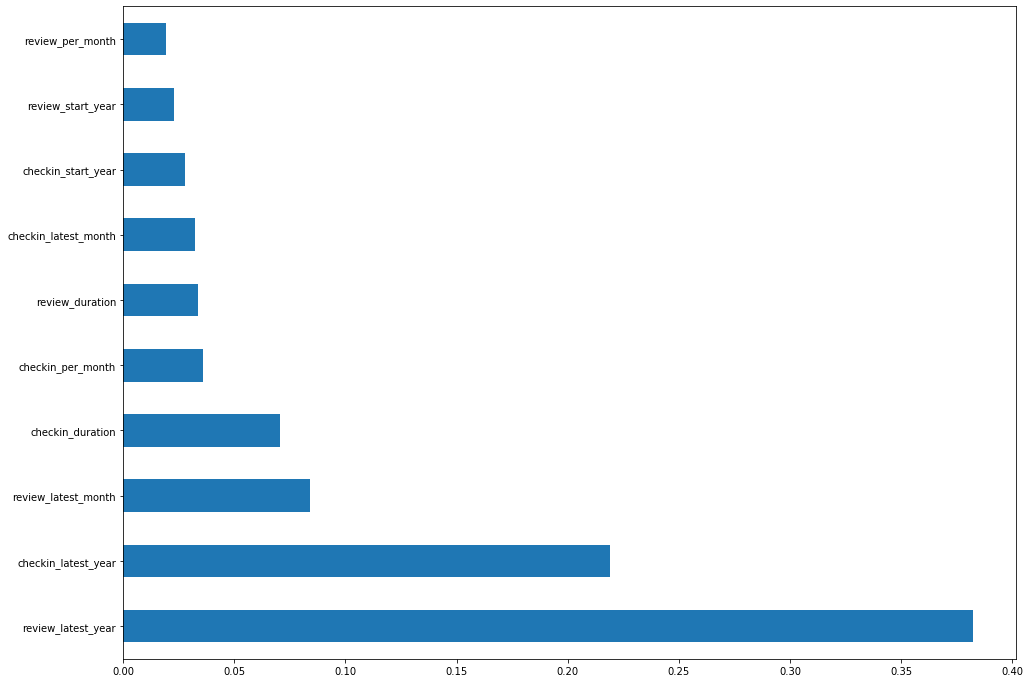

In [44]:
from sklearn.ensemble import RandomForestClassifier

def random_forests_classifer(X, y):
    # split the data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=21)
    # initialize random forests model
    rf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=21)
    # fit the model
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    # results
    print('Random Forests score for training set: %f' % rf.score(X_train, y_train))
    print('Random Forests score for testing set: %f' % rf.score(X_test, y_test))
    print('-----------------------------------------------------------')
    print(classification_report(y_test, y_pred))
    fig, axes = plt.subplots()
    fig.set_size_inches(16, 12)
    feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
    feature_importances.nlargest(10).plot(kind='barh')
    plt.show()

rf_X, rf_y = prepare_data(data)
random_forests_classifer(rf_X, rf_y)

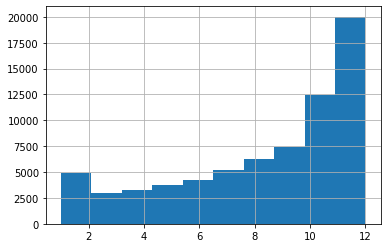

In [34]:
data_open['checkin_latest_month'].hist()

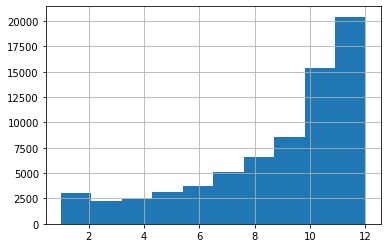

In [36]:
data_open['review_latest_month'].hist()